In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "image",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4687 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Rice__brown_spot',
 'Rice__healthy',
 'Rice__hispa',
 'Rice__leaf_blast',
 'Rice__neck_blast']

In [6]:
len(dataset)

147

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)
    

(256, 256, 3)


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 3 2 1 2 0 4 0 0 4 1 1 2 1 2 1 3 1 4 3 4 4 1 0 0 2 0 4 3 0 3 1]


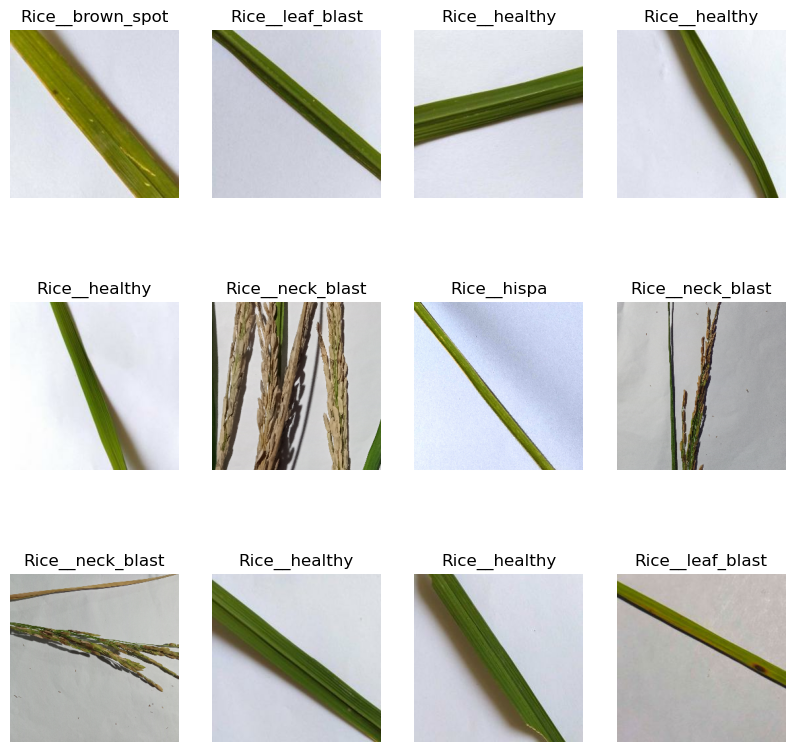

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# Train Test Split


In [10]:
len(dataset)

147

*80% ==> training*

*20% ==> 10% validation, 10% test*

In [11]:
train_size = 0.8
len(dataset)*train_size

117.60000000000001

In [12]:
train_ds = dataset.take(117)
len(train_ds)

117

In [13]:
test_ds = dataset.skip(117)
len(test_ds)

30

In [14]:
val_size = 0.1
len(dataset)* val_size

14.700000000000001

In [15]:
val_ds= test_ds.take(14)
len(val_ds)

14

In [16]:
test_ds = test_ds.skip(14)
len(test_ds)

16

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds =ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)


117

In [20]:
len(val_ds)


14

In [21]:
len(test_ds)


16

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Resize and Rescale

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
])

# Train a CNN Model

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential ([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
    
])

model.build(input_shape = input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

# Using the Adam Optimizer in TensorFlow

Compile Using Optimizers(Adam) as it is widely used in machine learning because it is efficient and adapts the learning rate for each parameter. 


In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
EPOCHS = 60


history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/60


117/117 [==============================] - 269s 2s/step - loss: 1.2588 - accuracy: 0.4502 - val_loss: 1.0590 - val_accuracy: 0.5424
Epoch 2/60
117/117 [==============================] - 177s 2s/step - loss: 1.0270 - accuracy: 0.5495 - val_loss: 1.0219 - val_accuracy: 0.5580
Epoch 3/60
117/117 [==============================] - 178s 2s/step - loss: 0.9265 - accuracy: 0.5951 - val_loss: 0.8453 - val_accuracy: 0.6562
Epoch 4/60
117/117 [==============================] - 176s 2s/step - loss: 0.8854 - accuracy: 0.6289 - val_loss: 0.7926 - val_accuracy: 0.6875
Epoch 5/60
117/117 [==============================] - 177s 2s/step - loss: 0.8214 - accuracy: 0.6571 - val_loss: 0.7309 - val_accuracy: 0.7054
Epoch 6/60
117/117 [==============================] - 177s 2s/step - loss: 0.8154 - accuracy: 0.6627 - val_loss: 0.8182 - val_accuracy: 0.6585
Epoch 7/60
117/117 [==============================] - 177s 2s/step - loss: 0.7512 - accuracy: 0.6914 - val_loss: 0.7670 - val_accuracy: 0.65

117/117 [==============================] - 177s 2s/step - loss: 0.3542 - accuracy: 0.8742 - val_loss: 0.6947 - val_accuracy: 0.7879
Epoch 55/60
117/117 [==============================] - 178s 2s/step - loss: 0.3566 - accuracy: 0.8785 - val_loss: 0.5422 - val_accuracy: 0.7790
Epoch 56/60
117/117 [==============================] - 177s 2s/step - loss: 0.3531 - accuracy: 0.8766 - val_loss: 0.4922 - val_accuracy: 0.8125
Epoch 57/60
117/117 [==============================] - 338s 3s/step - loss: 0.3569 - accuracy: 0.8742 - val_loss: 0.5628 - val_accuracy: 0.7835
Epoch 58/60
117/117 [==============================] - 425s 4s/step - loss: 0.3271 - accuracy: 0.8827 - val_loss: 0.4111 - val_accuracy: 0.8504
Epoch 59/60
117/117 [==============================] - 435s 4s/step - loss: 0.3423 - accuracy: 0.8838 - val_loss: 0.4599 - val_accuracy: 0.8438
Epoch 60/60
117/117 [==============================] - 442s 4s/step - loss: 0.3434 - accuracy: 0.8774 - val_loss: 0.3950 - val_accuracy: 0.8460


# Plot Training History on Chart


In [43]:
scores = model.evaluate(test_ds)

16/16 [==============================] - 12s 734ms/step - loss: 0.3409 - accuracy: 0.8906


In [44]:
history


In [45]:
history.params


{'verbose': 1, 'epochs': 60, 'steps': 117}

In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
history.history['accuracy']

[0.4502280652523041,
 0.5495036244392395,
 0.5951167345046997,
 0.6289240717887878,
 0.6570968627929688,
 0.662731409072876,
 0.6914408206939697,
 0.7019050121307373,
 0.7228333950042725,
 0.7102227210998535,
 0.7308827638626099,
 0.7397370338439941,
 0.7523477077484131,
 0.7759591937065125,
 0.7813254594802856,
 0.7874966263771057,
 0.78642338514328,
 0.8001073002815247,
 0.8116447329521179,
 0.801717221736908,
 0.8194258213043213,
 0.8253287076950073,
 0.8296216726303101,
 0.8156694173812866,
 0.8226455450057983,
 0.8331097364425659,
 0.8339146971702576,
 0.8355245590209961,
 0.8298900127410889,
 0.8352562189102173,
 0.8352562189102173,
 0.8408908247947693,
 0.8473302721977234,
 0.8521599173545837,
 0.8502817153930664,
 0.8524281978607178,
 0.8556479811668396,
 0.8572578430175781,
 0.8484035134315491,
 0.8602092862129211,
 0.8674536943435669,
 0.8467936515808105,
 0.8610142469406128,
 0.8655755519866943,
 0.8650389313697815,
 0.866917073726654,
 0.8736249208450317,
 0.860209286212921

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

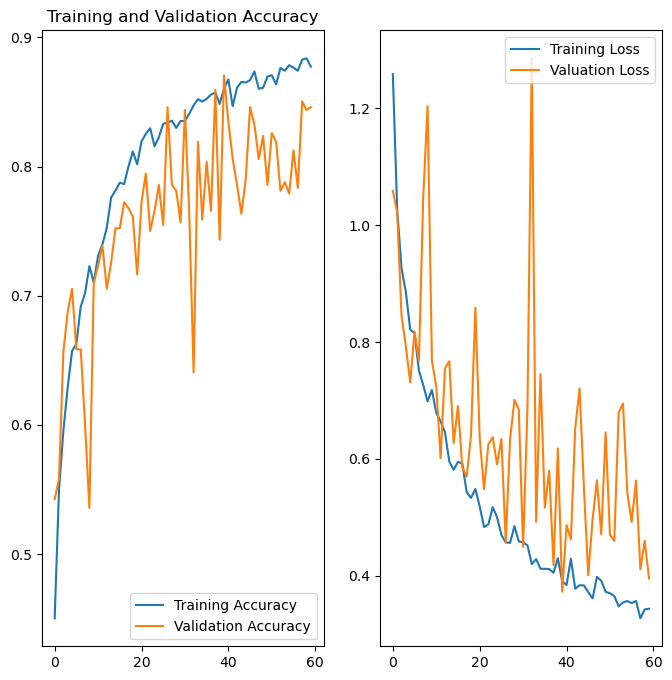

In [49]:
#Training and Validation Accuracy

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)

plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



#Training and Validation Loss

plt.subplot(1,2,2)

plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Valuation Loss')

plt.legend(loc = 'upper right')


# Make Predictions on Sample Images


first image to predict
actual label: Rice__brown_spot
1/1 [==============================] - 1s 982ms/step
predicted label Rice__healthy


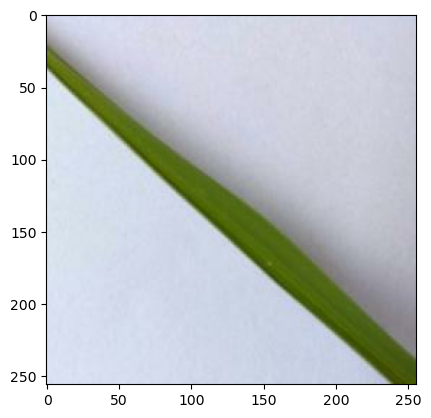

In [50]:
import numpy as np
for image_batch, labels_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print('actual label:', class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print('predicted label',class_names [np.argmax(batch_prediction[0])])

In [51]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


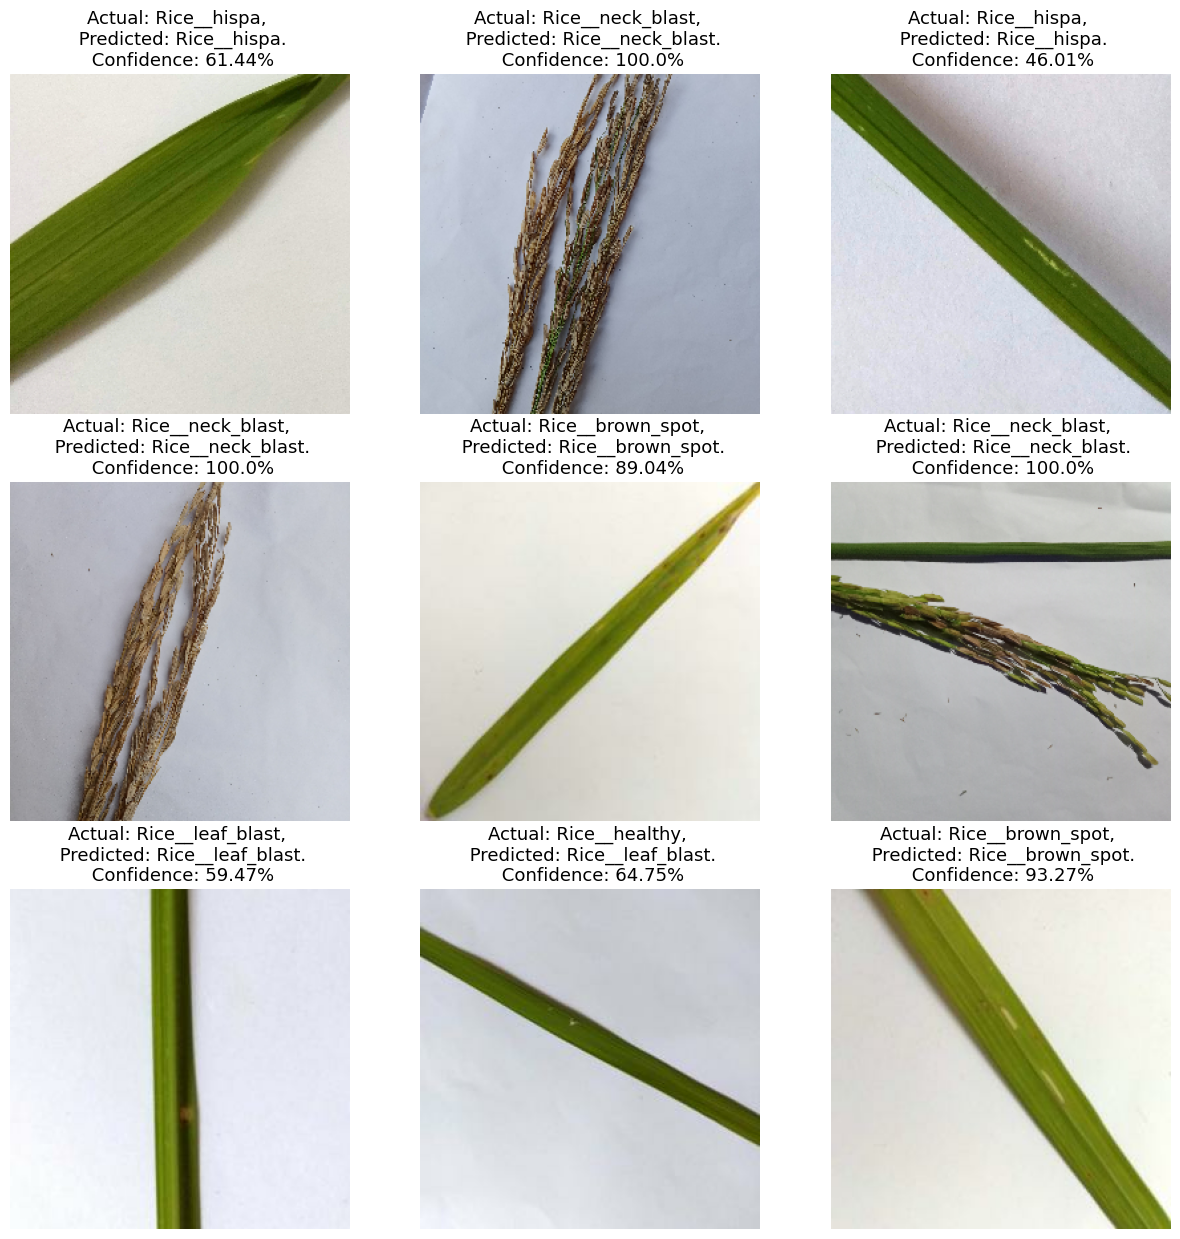

In [52]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%', fontsize=13)
        
        plt.axis('off')

In [39]:
model_version = 1
model.save(f'../models/{model_version}')

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
